In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import  train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

2024-06-07 03:00:50.508326: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 03:00:50.705252: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-07 03:00:50.705275: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-07 03:00:50.728315: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-07 03:00:53.395014: W tensorflow/stream_executor/platform/de

In [3]:
climate_data = pd.read_csv('climate.csv') # Read the data set
climate_data.shape # Display the shape of the data set

(540, 21)

In [4]:
# Define the loss function wich uses binary cross entropy loss to deal with binary classification problems
def loss_fn(targets, predictions): 
    return -tf.reduce_mean(targets * tf.math.log(predictions) + (1 - targets) * tf.math.log(1 - predictions))

In [5]:
# Define the sigmoid activation function
def sigmoid(inputs):
    return 1 / (1 + tf.exp(-inputs))

# Define the ReLU activation function
def relu(inputs):
    return tf.maximum(0, inputs)

# Define a forward propagator
def forward(inputs, weights, biases):
    hidden_layer_input = tf.add(tf.matmul(inputs, weights['hidden']), biases['hidden'])
    hidden_layer_output = relu(hidden_layer_input)
    output_layer_input = tf.add(tf.matmul(hidden_layer_output, weights['output']), biases['output'])
    output_layer_output = sigmoid(output_layer_input)
    return output_layer_output

In [6]:
# Define the training function
def train(inputs, targets, weights, biases, learning_rate=0.005):
    with tf.GradientTape() as tape:
        predictions = forward(inputs, weights, biases)
        loss = loss_fn(targets, predictions)

    gradients = tape.gradient(loss, [weights['hidden'], weights['output'], biases['hidden'], biases['output']])

    weights['hidden'].assign_sub(learning_rate * gradients[0])
    weights['output'].assign_sub(learning_rate * gradients[1])
    biases['hidden'].assign_sub(learning_rate * gradients[2])
    biases['output'].assign_sub(learning_rate * gradients[3])
    return loss, predictions

# Define model training and early stop functions
def fit(inputs, targets, x_val, y_val, weights, biases, epochs=100, learning_rate=0.1, batch_size=32):
    train_losses = []  
    val_losses = [] 
    best_val_loss = float('inf')
    patience = 10  # Patience parameter for early stop
    patience_counter = 0  # Track the number of times the validation loss has not improved

    for epoch in range(epochs):
        # Mini-batch
        for i in range(0, inputs.shape[0], batch_size):
            batch_inputs = inputs[i:i+batch_size]
            batch_targets = targets[i:i+batch_size]
            _, predictions = train(batch_inputs, batch_targets, weights, biases, learning_rate)
        
        # Calculate training losses
        train_loss = loss_fn(targets, predictions)
        train_losses.append(train_loss.numpy())
        
        # Calculate the verification loss
        val_predictions = forward(x_val, weights, biases)
        val_loss = loss_fn(y_val, val_predictions)
        val_losses.append(val_loss.numpy())

        min_delta = 0.01  # Minimum change threshold

        # Check for improvement
        if val_loss < best_val_loss - min_delta:  # is valid only if the improvement exceeds the min delta
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stop
        if patience_counter > patience:
            print(f"Early stopping at epoch {epoch}")
            break
        
        # Display the output training and validation losses every 10 epochs
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Training Loss: {train_loss.numpy():.6f}, Validation Loss: {val_loss.numpy():.6f}')

    return train_losses, val_losses

In [7]:
# Initialize model parameters
input_size = 18 # Input layer nodes, corresponding to the number of features
hidden_size = 100 # Number of hidden layer nodes
output_size = 1 # Output layer nodes, corresponding to the binary classification task

weights = {
    'hidden': tf.Variable(tf.random.normal([input_size, hidden_size], stddev=0.1), name='hidden_weights'),
    'output': tf.Variable(tf.random.normal([hidden_size, output_size], stddev=0.1), name='output_weights')
}
biases = {
    'hidden': tf.Variable(tf.random.normal([hidden_size], stddev=0.1), name='hidden_biases'),
    'output': tf.Variable(tf.random.normal([output_size], stddev=0.1), name='output_biases')
}

2024-06-07 03:01:16.918467: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-07 03:01:16.930916: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-07 03:01:16.930961: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (codespaces-3393b3): /proc/driver/nvidia/version does not exist
2024-06-07 03:01:17.013398: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
features = climate_data.drop(columns=['Study', 'Run', 'outcome'])
label = climate_data['outcome']

# Data set separation function
def split(features, label):
    x_train, x_val_test, y_train, y_val_test = train_test_split(features, label, test_size = 0.3, random_state = 77)
    x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size = 2/3, random_state = 77)
    return x_train, y_train, x_val, y_val, x_test, y_test

x_train, y_train, x_val, y_val, x_test, y_test = split(features, label)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(378, 18)
(54, 18)
(108, 18)


In [9]:
# Feature normalization function
def normalize_features(features):
    mean = np.mean(features, axis=0)
    std = np.std(features, axis=0)
    features_normalized = (features - mean) / std
    return features_normalized, mean, std

# Normalize training set, validation set, and test set features
x_train_normalized, mean1, std1 = normalize_features(x_train)
x_val_normalized = (x_val - mean1) / std1
x_test_normalized = (x_test - mean1) / std1

# Convert to TensorFlow tensor
x_train_normalized = tf.cast(x_train_normalized, tf.float32)
x_val_normalized = tf.cast(x_val_normalized, tf.float32)
x_test_normalized = tf.cast(x_test_normalized, tf.float32)
y_train = tf.cast(y_train, tf.float32)
y_val = tf.cast(y_val, tf.float32)
y_test = tf.cast(y_test, tf.float32)

In [10]:
model = {
    'weights': weights,
    'biases': biases
}

# Set training parameters
epochs = 100
learning_rate = 0.005

# Training model
train_losses, val_losses = fit(x_train_normalized, y_train, x_val_normalized, y_val, weights, biases, epochs, learning_rate)

print("Final training loss:", train_losses[-1])
print("Final validation loss:", val_losses[-1])


Epoch 0, Training Loss: 0.645436, Validation Loss: 0.614716
Epoch 10, Training Loss: 0.433320, Validation Loss: 0.386805
Epoch 20, Training Loss: 0.366077, Validation Loss: 0.307786
Epoch 30, Training Loss: 0.340071, Validation Loss: 0.273329
Epoch 40, Training Loss: 0.328623, Validation Loss: 0.255807
Epoch 50, Training Loss: 0.323157, Validation Loss: 0.245912
Early stopping at epoch 54
Final training loss: 0.32183293
Final validation loss: 0.2431645


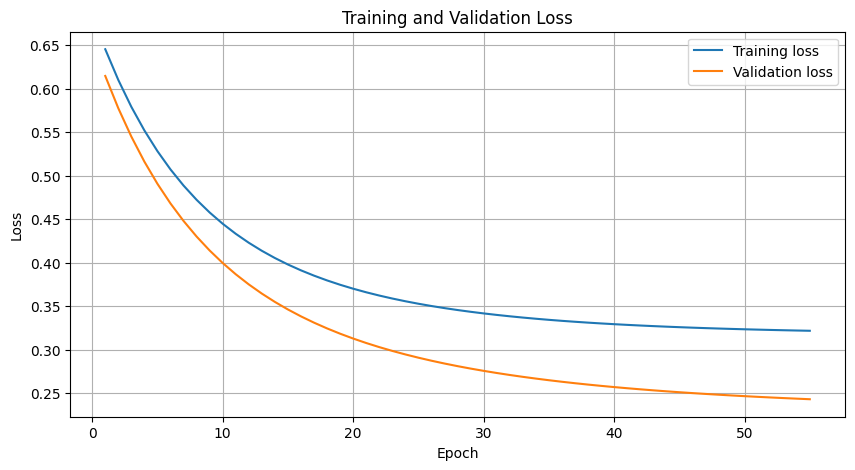

In [11]:
# Plot the loss curve
def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Training loss')
    plt.plot(epochs, val_losses, label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses, val_losses)

In [12]:
# Define the prediction function
def predict(model, inputs):
    outputs = forward(inputs, model['weights'], model['biases'])
    return tf.cast(tf.greater(outputs, 0.5), tf.int32)  

# Predictive test set
predicted_classes = predict(model, x_test_normalized)

In [13]:
# Evaluation model
true_classes = y_test
confu_matrix = confusion_matrix(true_classes.numpy(), predicted_classes.numpy())
class_report = classification_report(true_classes.numpy(), predicted_classes.numpy())

print("Confusion Matrix:")
print(confu_matrix)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[  0   7]
 [  0 101]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.94      1.00      0.97       101

    accuracy                           0.94       108
   macro avg       0.47      0.50      0.48       108
weighted avg       0.87      0.94      0.90       108



/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
